In [1]:
#Chargement des données: customer.csv, countryPopulation.csv, countryGDP.csv
import pandas as pd # importation du module pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

customer = pd.read_csv("customer.csv")
countryPopulation = pd.read_csv("countryPopulation.csv")
countryGDP = pd.read_csv("countryGDP.csv")


# Devoir 1 - 8IAR403
Étudiant : *Mael Garnier*


Plan :
1. Récupération des données
    - a. Examen de la structure des données
    - b. Création d'un jeu de test
2. Mieux comprendre les données
3. Nettoyage des données
    - a. Remplacement des valeurs manquantes
    - b. Remplacement des données aberrantes
4. Enrichissement des données
5. Pipeline de transformation

## 1. Récupération des données

### a. Examen de la structure des données

Nous pouvons commencer par examiner les données des clients issues du fichier `customer.csv`.

In [2]:
customer.head()

,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue
0,41.0,6.0,28.0,Fem,False,4.0,China,113
1,34.0,4.0,15.5,Fem,True,2.0,China,36
2,38.0,5.0,?,Fem,False,7.0,China,111
3,20.0,1.0,44.0,Fem,False,2.0,China,71
4,39.0,10.0,10.0,Fem,True,4.0,China,80


Nous avons un premier apercu des données avec les CINQ premières lignes.
Nous remarquons que nous avons les variables suivantes :
- `age`
- `pages`
- `first_item_prize`
- `gender`
- `ReBuy`
- `News_Click`
- `country`
- `revenue`

Nous avons quelques exemples de données, et nous pouvons déjà remarquer que certaines variables sont manquantes, remplacées par exemple par le caractère `?`.

Utilisons la methode `info()` pour obtenir une description des données.

In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  10000 non-null  object 
 3   gender            10000 non-null  object 
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   country           10000 non-null  object 
 7   revenue           10000 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 556.8+ KB


Nous remarqons qu'il y a **10 000 lignes** et **8 colonnes**.
Nous avons différents types de variables : `float64` (quantitatif), `object` (qualitatif) et `bool` (qualitatif).

A noter que certaines colonnes dont les variables sont de type `object` sont peut-être des variables quantitatives dont certaines valeurs sont manquantes et ont été remplacées par *?* ou *unknown*.

Nous pouvons obtenir plus d'informations sur des variables spécifiques.
Nous remarquons ci-dessous que 462 personnes ont 35 ans, 461 ont 36 ans ou encore 454 ont 38 ans.

In [4]:
customer['age'].value_counts()

age
35.0    462
36.0    461
38.0    454
34.0    447
37.0    441
       ... 
65.0     10
63.0     10
71.0      9
75.0      9
70.0      6
Name: count, Length: 62, dtype: int64

Examinons maintenant un récapitulatif des variables numériques.

In [5]:
customer.describe()

,age,pages,News_click
count,10000.000000,10000.000000,10000.000000
mean,37.431400,5.995000,4.412000
std,9.490474,2.438559,2.418231
min,18.000000,1.000000,0.000000
25%,31.000000,5.000000,3.000000
50%,37.000000,6.000000,4.000000
75%,43.000000,7.000000,6.000000
max,79.000000,14.000000,10.000000


Les variables `age`, `pages`, et `News_click` sont des variables numériques.

Nous avons des données interessantes :
- La moyenne d'age est environ de 37.43 ans
- La moyenne de page visitée est environ de 6.00
- Le nombre de clicks sur des campagnes de publicité est en moyenne de 4.41
- L'ecart type de l'age est de 9.49 ans
- le maximum de pages visitées est de 14


Faisons nous maintenant une idée des données en construisant des histogrammes.

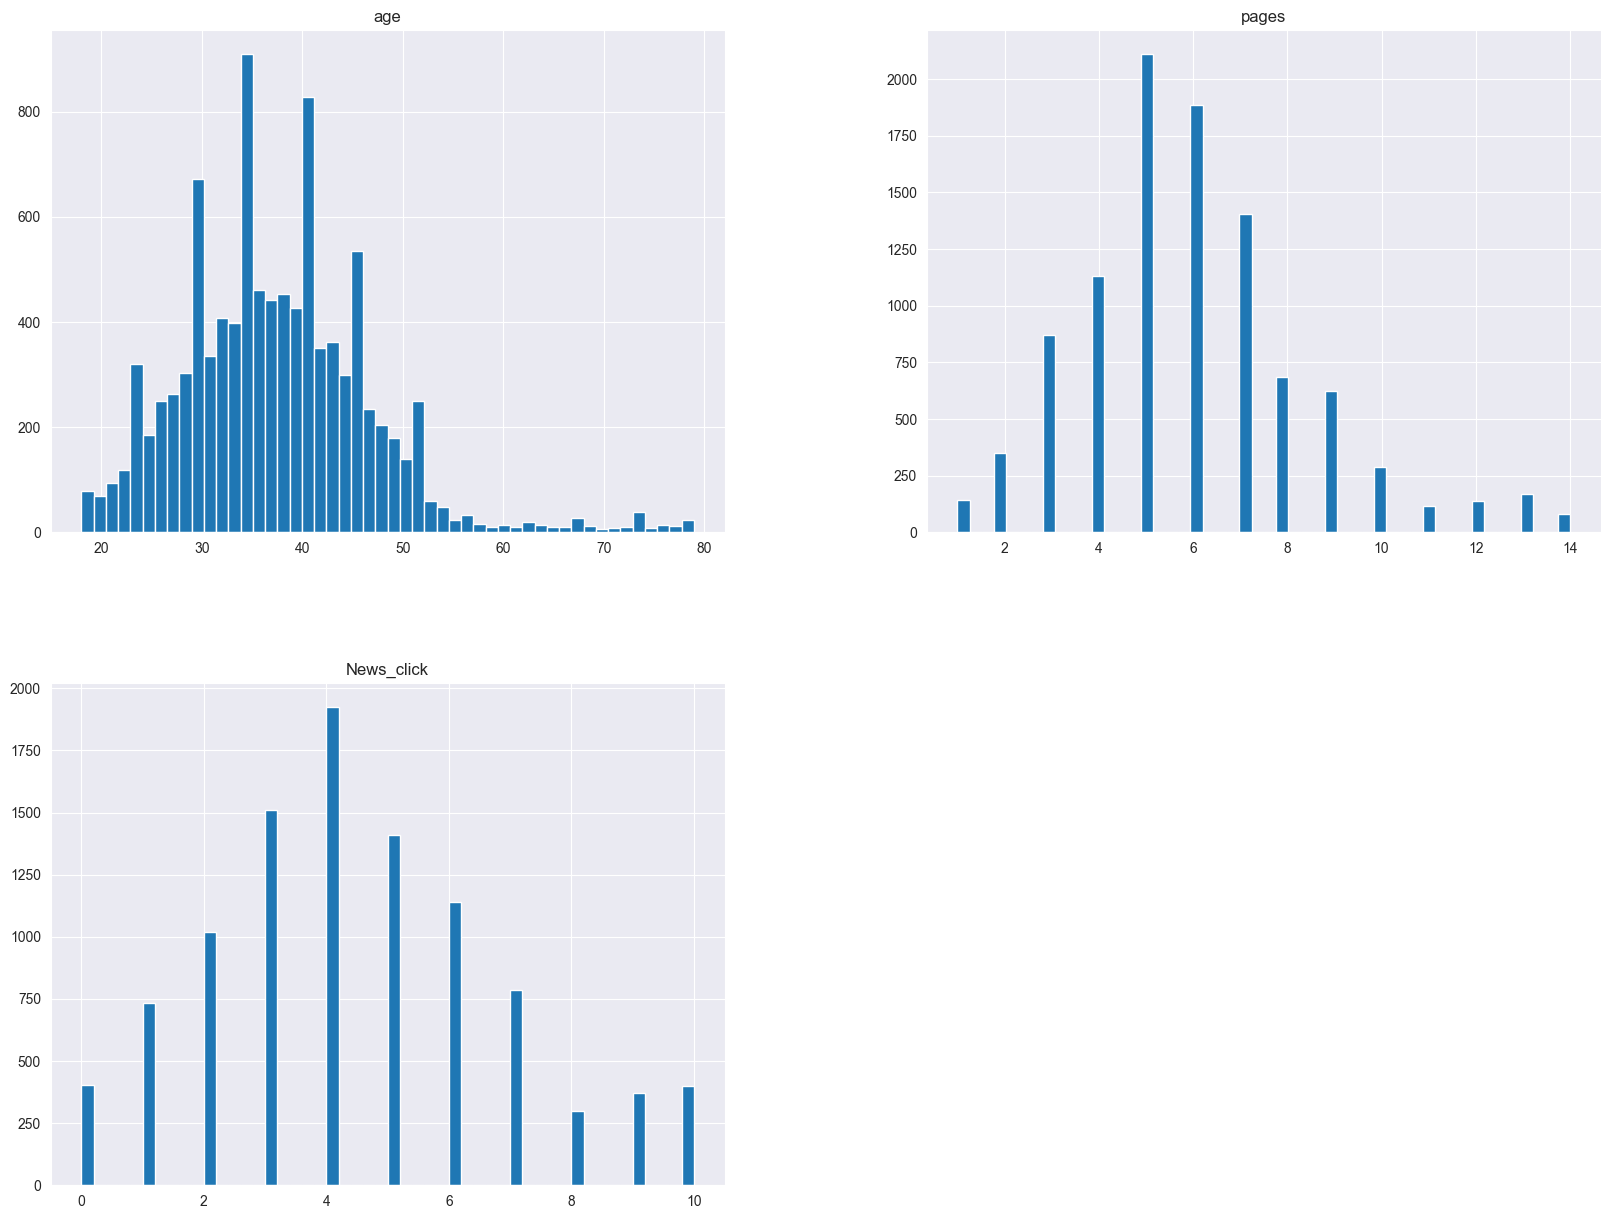

In [6]:
customer.hist(bins=50, figsize=(20,15))
plt.show()

### b. Création d'un jeu de test

Le jeu de données étant assez important, nous n'avons pas besoin d'introduire un biais d'échantillonnage.

Nous pouvons ainsi créer notre jeu de test à partir des données existantes, en prenant 20% aléatoirement.

In [7]:
train_set, test_set = train_test_split(customer, test_size=0.2,
                                       random_state=5)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 7054 to 3081
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2000 non-null   float64
 1   pages             2000 non-null   float64
 2   first_item_prize  2000 non-null   object 
 3   gender            2000 non-null   object 
 4   ReBuy             2000 non-null   bool   
 5   News_click        2000 non-null   float64
 6   country           2000 non-null   object 
 7   revenue           2000 non-null   object 
dtypes: bool(1), float64(3), object(4)
memory usage: 127.0+ KB


## 2. Mieux comprendre les données

Commençons par faire une copie du jeu de données d'entrainement pour le manipuler sans détériorer l'original.

In [8]:
train_set_copy = train_set.copy()

Nous pouvons calculer le coefficient de corrélation de Pearson entre les variables numériques restantes. Cela permet de quantifier la relation linéaire entre ces variables.

                 age     pages  News_click
age         1.000000  0.001249   -0.008452
pages       0.001249  1.000000   -0.011475
News_click -0.008452 -0.011475    1.000000


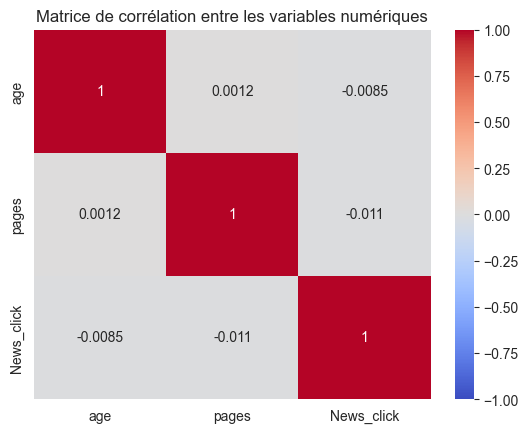

In [9]:
# Calcul des corrélations entre les variables numériques
correlation_matrix = train_set_copy[['age', 'pages', 'News_click']].corr()
print(correlation_matrix)

# Heatmap pour visualiser les corrélations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre les variables numériques")
plt.show()


Des valeurs proches de 1 ou -1 signifient une forte correlation. Grace a ce graphique, on peut réaliser que les variables `age`, `pages`, et `News_click` sont très peu corrélées entre elles.

## 3. Nettoyage des données

### a. Remplacement des valeurs manquantes

Commencons par récolter des informations sur le type des colonnes sur la nouvelle version de customer.

In [10]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 7054 to 3081
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2000 non-null   float64
 1   pages             2000 non-null   float64
 2   first_item_prize  2000 non-null   object 
 3   gender            2000 non-null   object 
 4   ReBuy             2000 non-null   bool   
 5   News_click        2000 non-null   float64
 6   country           2000 non-null   object 
 7   revenue           2000 non-null   object 
dtypes: bool(1), float64(3), object(4)
memory usage: 127.0+ KB


Etan donné que le jeu de données contient 2000 entrées et que chacune des colonnes contiennent 2000 elements, nous pouvons en déduire que les valeurs manquantes seront sous la forme d'objets `?`, `unknown` ou autre.

Les variables `first_item_prize`, `gender`, `country`, et `revenue` sont de type `object`. Or, en consultant les quelques lignes du jeu de données, nous remarquons rapidement que les variables `first_item_prize` et `revenue` sont des données quantitatives. Ce sont donc les données que nous allons devoir traiter dans le nettoyage, pour pouvoir les transformer en type numérique.

Notre stratégie va être la suivante :
- **Etape 1** : Dans les deux colonnes `first_item_prize` et `revenue`, nous allons remplacer les valeurs manquantes (que nous allons identifier en recherchant les valeurs qui ne peuvent pas êtres convertis en nombre) par `NaN`.
- **Etape 2** : Nous allons convertir les colonnes `first_item_prize` et `revenue` en types numériques (`int64` et `float64` respectivement) grace a la fonction `to_numeric()` de Pandas.
- **Etape 3** : Nous allons utiliser SimpleImputer pour calculer la médiane de ces colonnes et remplacer les valeurs manquantes par cette médiane.

Cette stratégie sera implémentée dans une seule fonction (commentée) replace_missing_values qui prends en paramètre notre DataFrame, soit `customer`.

In [11]:
# Cette fonction va effectuer les actions suivantes :
# 1. Dans les colonnes mentionnées dans cols_to_numeric, on remplace les valeurs manquantes (qu'on identifie comme des valeurs qui ne peuvent pas être transformées en valeurs quantitatives) par NaN
# 2. On convertit les colonnes cols_to_numeric en types numériques (respectivement int64 et float64)
# 3. On remplace les valeurs manquantes par la médiane de ces colonnes avec SimpleImputer
def replace_missing_values_function(X, cols_to_numeric, cols_to_exclude):

    for col in cols_to_numeric:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # ETAPE 3
    # Instanciation de la classe SimpleImputer
    imputer = SimpleImputer(strategy="median")

    # Séparer les colonnes numériques
    x_num = X.drop(columns=cols_to_exclude, axis=1)

    # On applique la méthode fit() de l'objet imputer à notre jeu de données
    imputer.fit(x_num)

    # On utilise maintenant cet imputer entrainé pour remplacer les valeurs manquantes par la médiane
    x_num_tr = imputer.transform(x_num)

    # On recrée un DataFrame avec les valeurs manquantes remplacées
    x_tr = pd.DataFrame(x_num_tr, columns=x_num.columns,
                          index=X.index)

    # Réintégrer les colonnes qualitatives
    x_tr[cols_to_exclude] = X[cols_to_exclude]

    return x_tr

# On applique la fonction à notre jeu de données
test_set = replace_missing_values_function(test_set, cols_to_numeric=["first_item_prize", "revenue"], cols_to_exclude=["gender", "ReBuy", "country"])
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 7054 to 3081
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2000 non-null   float64
 1   pages             2000 non-null   float64
 2   first_item_prize  2000 non-null   float64
 3   News_click        2000 non-null   float64
 4   revenue           2000 non-null   float64
 5   gender            2000 non-null   object 
 6   ReBuy             2000 non-null   bool   
 7   country           2000 non-null   object 
dtypes: bool(1), float64(5), object(2)
memory usage: 127.0+ KB


Nous remarquons que suite à execution de la fonction, les colonnes `first_item_prize` et `revenue` ont été converties en types numériques (`float64`) et les valeurs manquantes ont été remplacées par la médiane de ces colonnes.

On peut maintenant transformer la fonction en transformateur, pour pouvoir plus tard l'integrer facilement dans un pipeline de transformation.



In [12]:
replace_missing_values_customer = FunctionTransformer(
    replace_missing_values_function,
    validate=False,
    kw_args={
        "cols_to_numeric": ["first_item_prize", "revenue"],
        "cols_to_exclude": ["gender", "ReBuy", "country"]
    }
)

### b. Remplacement des données aberrantes

Nous voulons savoir si certaines données s'écartent significativement des autres observations dans notre jeu de données.

Pour cela, nous allons commencer par visualiser les données grace a un graphique de type `boxplot` (ou boîte à moustaches).

<Axes: >

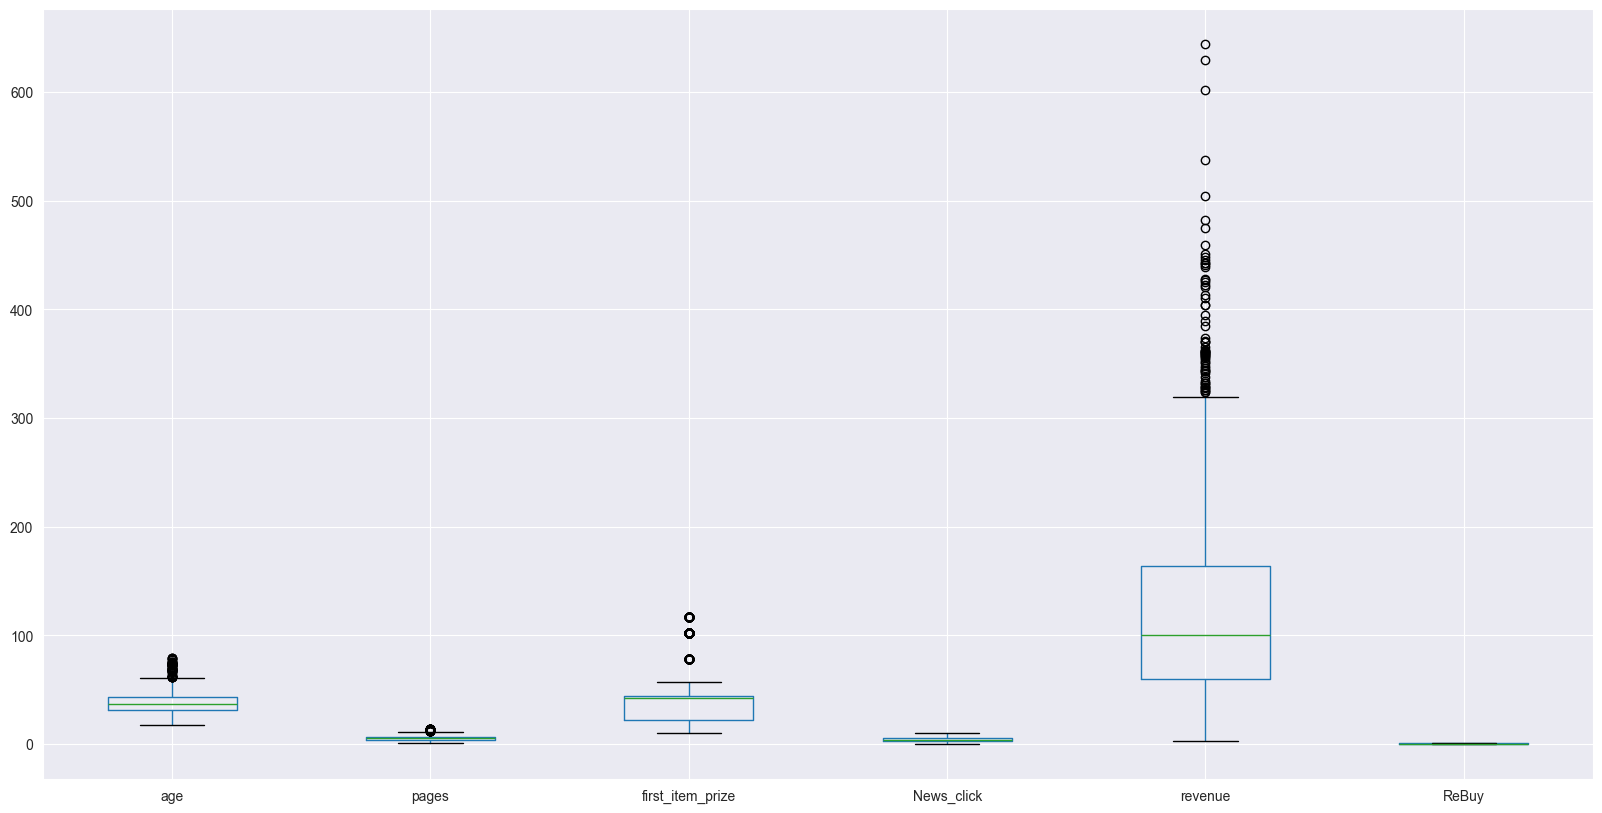

In [13]:
test_set.boxplot(figsize=(20,10))

Afin d'identifier des données aberrantes, nous recherchons les données se trouvant au-dessus de la *moustache supérieure*.

Dans le graphique ci-dessus, nous remarquons rapidement que la variable `revenue` contient des données aberrantes, car nous remarquons des points (et donc des valeurs) qui se trouvent au-dessus de la *moustache supérieure*.

Cela signifie que la variable `revenue` contient des données aberrantes que nous devrons remplacer.

Mais les données de cette variable sont beaucoup plus élevées que toutes les autres, ainsi nous ne pouvons correctement visualiser les autres variables.

Pour cela, nous allons isoler temporairement la variable `revenue`.

<Axes: >

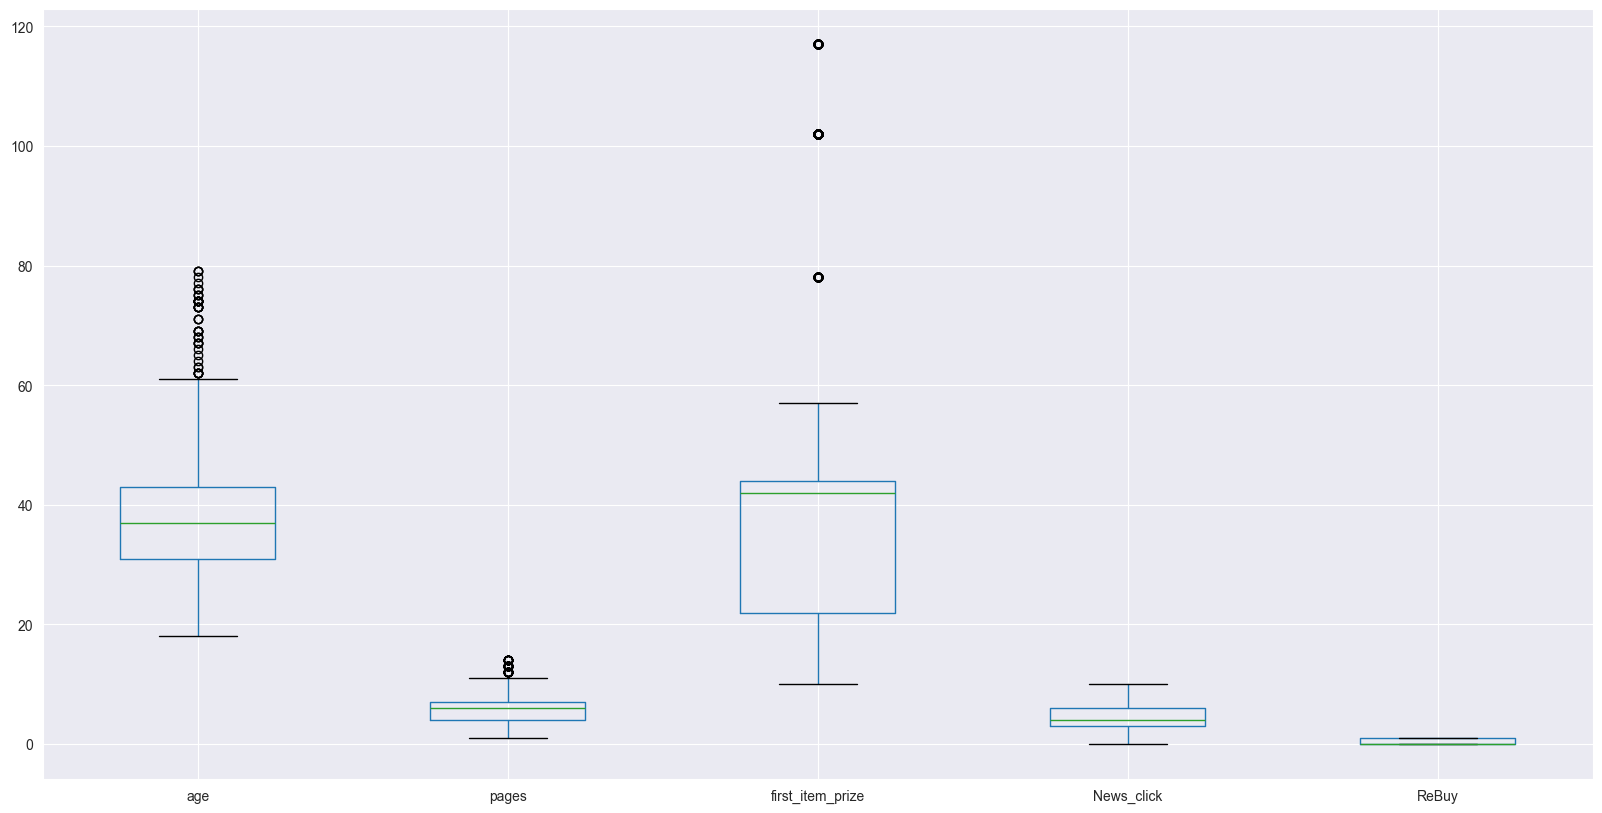

In [14]:
customer_without_revenue = test_set.drop(columns=["revenue"], axis=1)
customer_without_revenue.boxplot(figsize=(20,10))

Maintenant, nous remarquons que les variables `age`, `pages` et `first_item_prize` ont toutes des données aberrantes, pour la meme raison que la variable `revenue`.

Cependant, la donnée aberrante la plus élevée pour `age` est 80, or cela reste une valeur plausible. Nous allons donc nous concentrer sur les variables `pages`, `first_item_prize` et `revenue`.


<Axes: >

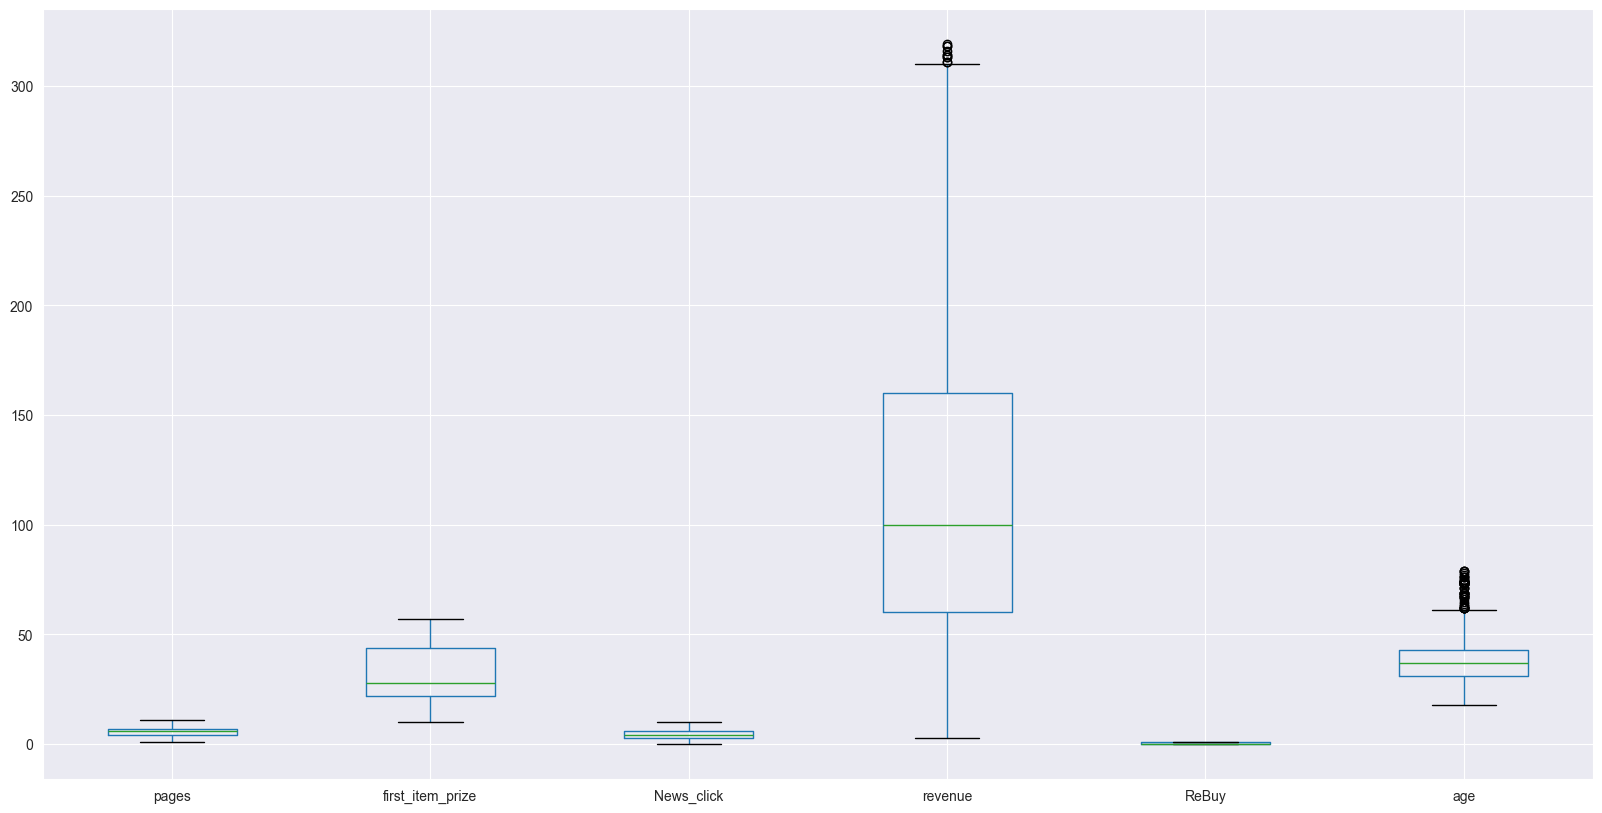

In [15]:
def replace_outliers_with_interpolation_function(X, cols_to_exclude):

    # Séparer les colonnes numériques
    x_num = X.drop(columns=cols_to_exclude, axis=1)

    # Calcul des quartiles et de l'IQR pour chaque variable
    Q1 = x_num.quantile(0.25)
    Q3 = x_num.quantile(0.75)
    IQR = Q3 - Q1

    # Définition des bornes inférieure et supérieure
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remplacement des valeurs aberrantes par interpolation
    # On itère sur chaque colonne
    # Utilisation de np.where pour remplacer les valeurs aberrantes par NaN
    # Utilisation de la méthode interpolate() pour remplacer les NaN par des valeurs interpolées
    for column in x_num.columns:
        x_num[column] = np.where(
            (x_num[column] < lower_bound[column]) | (x_num[column] > upper_bound[column]),
            np.nan,
            x_num[column]
        )

        # L'interpolation en suivant une methode linéaire ne donnera pas des résultats satisfaisant pour la colonne revenue, car les données ne suivent pas exactement un patterne linéaire et certaines données pourront toujours se trouver en dehors des bornes.
        # On utilise donc la méthode slinear qui est une interpolation linéaire plus souple
        x_num[column] = x_num[column].interpolate(method='slinear', limit_direction='both')

    # Réintégrer les colonnes qualitatives
    x_num[cols_to_exclude] = X[cols_to_exclude]

    return x_num

# On applique la fonction à notre jeu de données
test_set = replace_outliers_with_interpolation_function(test_set, ["gender", "ReBuy", "country", "age"])

test_set.boxplot(figsize=(20,10))

On remarque que nos données aberrantes ont presque toutes disparues. Seulement quelques-unes subsistent pour la variable `revenue`, mais sont négligeables, car peu nombreuses et très proche de la limite.

Nous pouvons maintenant transformer la fonction en transformateur, pour pouvoir plus tard l'integrer facilement dans un pipeline de transformation.

In [16]:
replace_outliers_customer = FunctionTransformer(
    replace_outliers_with_interpolation_function,
    validate=False,
    kw_args={
        "cols_to_exclude": ["gender", "ReBuy", "country", "age"]
    }
)

## 4. Enrichissement des données

Commencons par étudier le contenu de nos deux nouveaux jeux de données `countryPopulation` et `countryGDP`.

In [17]:
countryGDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    188 non-null    object
 1   GDP_inhab  188 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ KB


Dans le cas de countryGDP nous avons deux colonnes dont l'une est de type `object` et l'autre de type `int64`. Cela est correct, nous n'avons pas besoin de faire de correction sur les types.

In [18]:
countryPopulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Country     220 non-null    object
 1   population  220 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


Nous pouvons faire les memes observations pour countryPopulation.

Nous allons maintenant pouvoir réaliser la fonction permettant d'enrichir notre jeu de données `customer` avec les données de `countryPopulation`, et `countryGDP` si besoins.

Notre stratégie va être la suivante :
- **Etape 1** : Nous allons remplacer les valeurs manquantes dans le nouveau jeu de données.
- **Etape 2** : Nous allons corriger le titre de la colonne `Country` pour pouvoir faire une jointure.
- **Etape 3** : Nous allons mettre en minuscule les noms des pays pour pouvoir faire une jointure.
- **Etape 4** : Nous allons faire une jointure entre notre jeu de données et le nouveau jeu de données.

Cette stratégie sera implémentée dans une seule fonction (commentée) data_enrichment_function qui prends en paramètre notre DataFrame, soit `customer`, ainsi qu'un bouleen `addPIB` pour savoir si nous voulons ajouter les données de `countryGDP` ou non.

In [33]:
# X est le dataframe customer
def data_enrichment_function(X, addPIB):
    # On remplace les valeurs manquantes dans nos deux nouveaux jeux de données
    new_countryPopulation = replace_missing_values_function(countryPopulation, cols_to_numeric=[], cols_to_exclude=["Country"])

    # On corrige le titre de la colonne Country pour pouvoir faire une jointure
    new_countryPopulation.rename(columns={'Country': 'country'}, inplace=True)

    # On met en minuscule les noms des pays pour pouvoir faire une jointure
    X['country'] = X['country'].str.lower()
    new_countryPopulation['country'] = new_countryPopulation['country'].str.lower()

    # On fait une jointure entre notre jeu de données et le nouveau jeu de données
    merged_df = pd.merge(X, new_countryPopulation, on='country', how='left')

    # Si on veut ajouter les données de countryGDP
    if addPIB :
        new_countryGDP = replace_missing_values_function(countryGDP, cols_to_numeric=[], cols_to_exclude=["Country"])
        new_countryGDP.rename(columns={'Country': 'country'}, inplace=True)
        new_countryGDP['country'] = new_countryGDP['country'].str.lower()
        merged_df = pd.merge(merged_df, new_countryGDP, on='country', how='left')

    return merged_df

test_set = data_enrichment_function(test_set, addPIB=True)
test_set.head()

,pages,first_item_prize,News_click,revenue,gender,ReBuy,country,age,population_x,GDP_inhab_x,population_y,GDP_inhab_y,population,GDP_inhab
0,5.00,44.0,5.0,269.4,Fem,False,canada,46.0,35295770.0,42317.0,35295770.0,42317.0,35295770.0,42317.0
1,6.00,44.0,5.0,285.0,Fem,False,united states,43.0,317638000.0,51704.0,317638000.0,51704.0,317638000.0,51704.0
2,3.00,22.0,4.0,215.0,Fem,False,france,47.0,65844000.0,35295.0,65844000.0,35295.0,65844000.0,35295.0
3,7.00,28.0,4.0,74.0,Fem,False,philippines,49.0,99216300.0,4380.0,99216300.0,4380.0,99216300.0,4380.0
4,6.25,22.0,4.0,261.0,Fem,True,germany,35.0,80619000.0,38666.0,80619000.0,38666.0,80619000.0,38666.0


Nous remarquons que nous avons maintenant enrichi notre jeu de données avec les données de `countryPopulation` et `countryGDP`.

Nous pouvons maintenant transformer la fonction en transformateur, pour pouvoir plus tard l'intégrer facilement dans un pipeline de transformation.

In [57]:
data_enrichment = FunctionTransformer(
    data_enrichment_function,
    validate=False,
    kw_args={
        "addPIB": True
    },
)

## 5. Pipeline de transformation

Nous allons maintenant pouvoir construire notre pipeline de transformation, puis l'appliquer à notre jeu de données d'entrainement.

In [59]:

# Création du pipeline
data_cleaning = Pipeline([
    ("replace_missing", replace_missing_values_customer),
    ("replace_outliers", replace_outliers_customer),
])

new_columns = list(train_set.columns) + ["population", "GDP_inhab"]

full_pipeline = ColumnTransformer(
    transformers=[
        ("cleaning", data_cleaning, train_set.columns),
        ("enrichment", data_enrichment, train_set.columns)
    ],
    remainder="passthrough"
)


customer_prepare = full_pipeline.fit_transform(train_set)